In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Column names from wdbc.names
columns = ['ID', 'Diagnosis'] + [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

# Load dataset
df = pd.read_csv("wdbc.data", header=None, names=columns)

# Drop ID column
df.drop("ID", axis=1, inplace=True)

# Extract labels (optional - not used in clustering)
y = df["Diagnosis"]
df.drop("Diagnosis", axis=1, inplace=True)

# Preprocessing pipeline
def preprocess_data(X, method):
    if method == "original":
        return X.values
    elif method == "normalize":
        return StandardScaler().fit_transform(X)
    elif method == "transform":
        return PowerTransformer().fit_transform(X)
    elif method == "pca":
        return PCA(n_components=2).fit_transform(X)
    elif method == "T+N":
        X_trans = PowerTransformer().fit_transform(X)
        return StandardScaler().fit_transform(X_trans)
    elif method == "T+N+PCA":
        X_trans = PowerTransformer().fit_transform(X)
        X_norm = StandardScaler().fit_transform(X_trans)
        return PCA(n_components=2).fit_transform(X_norm)

# Evaluation function
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

preprocess_methods = ["original", "normalize", "transform", "pca", "T+N", "T+N+PCA"]
results = []

for method in preprocess_methods:
    X_proc = preprocess_data(df, method)

    for c in [3, 4, 5]:
        # KMeans
        km_labels = KMeans(n_clusters=c, random_state=42).fit_predict(X_proc)
        km_sil, km_ch, km_db = evaluate_clustering(X_proc, km_labels)
        results.append(["KMeans", method, c, km_sil, km_ch, km_db])

        # Hierarchical
        h_labels = AgglomerativeClustering(n_clusters=c).fit_predict(X_proc)
        h_sil, h_ch, h_db = evaluate_clustering(X_proc, h_labels)
        results.append(["Hierarchical", method, c, h_sil, h_ch, h_db])

    # Mean Shift (auto clusters)
    try:
        ms_labels = MeanShift().fit_predict(X_proc)
        if len(np.unique(ms_labels)) > 1:
            ms_sil, ms_ch, ms_db = evaluate_clustering(X_proc, ms_labels)
            results.append(["MeanShift", method, len(np.unique(ms_labels)), ms_sil, ms_ch, ms_db])
    except Exception as e:
        print(f"MeanShift failed for {method}: {e}")

# Save results
results_df = pd.DataFrame(results, columns=["Algorithm", "Preprocessing", "Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(results_df)
results_df.to_csv("wdbc_clustering_results.csv", index=False)


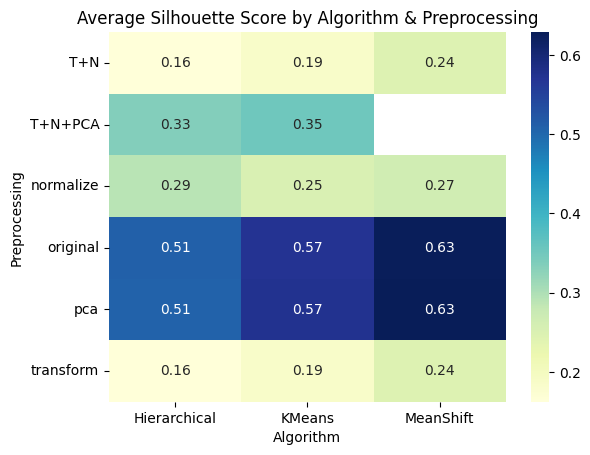

In [4]:
# Heatmap of average silhouette scores by algorithm and preprocessing
pivot = results_df.pivot_table(values='Silhouette', index='Preprocessing', columns='Algorithm')
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Average Silhouette Score by Algorithm & Preprocessing")
plt.show()